In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import folium
from folium.plugins import HeatMap
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler


# Dataset

In [4]:
# Load main dataset
maindf = pd.read_parquet(
    "/Users/francescatubaro/Desktop/Wintersemester1/Data Literacy/project/vehicle_events_maindataset.parquet",
    engine = 'fastparquet'
)

# Load matching candidates
cand = pd.read_parquet(
    "/Users/francescatubaro/Desktop/Wintersemester1/Data Literacy/project/matching_candidates_scored.parquet",
    engine="fastparquet"
)

print(f"Main dataset: {len(maindf):,} rows")
print(f"Candidates: {len(cand):,} rows")

Main dataset: 16,476,198 rows
Candidates: 45,278,301 rows


In [5]:
# Select best match for each disappearance event
best_matches = cand.loc[
    cand.groupby("d_idx")["prob"].idxmax()
].copy()

# Filter by probability threshold
PROB_NULL_THRESHOLD = 0.5

trips = best_matches[
    best_matches["prob_null"] < PROB_NULL_THRESHOLD
].copy()

print(f"Best matches: {len(best_matches):,}")
print(f"After prob_null filter: {len(trips):,}")

Best matches: 2,168,534
After prob_null filter: 2,103,967


In [6]:
# Parse timestamps as UTC
trips["d_time"] = pd.to_datetime(trips["d_time"], utc=True, errors="coerce")
trips["f_time"] = pd.to_datetime(trips["f_time"], utc=True, errors="coerce")
trips = trips.dropna(subset=["d_time", "f_time"])

# Convert to local time (CET/CEST)
trips["d_time_local"] = trips["d_time"].dt.tz_convert("Europe/Berlin")
trips["f_time_local"] = trips["f_time"].dt.tz_convert("Europe/Berlin")

# Derive local calendar variables
trips["trip_day"] = trips["d_time_local"].dt.floor("D")
trips["hour"] = trips["d_time_local"].dt.hour
trips["dow"] = trips["d_time_local"].dt.dayofweek  # 0=Mon, 6=Sun
trips["is_weekend"] = trips["dow"] >= 5

# Duration check
trips["delta_check_hours"] = (
    (trips["f_time"] - trips["d_time"]).dt.total_seconds() / 3600
)

# Extract provider and city
trips["provider"] = trips["provider"].astype(str).str.lower()
trips["provider_brand"] = trips["provider"].str.split("_").str[0]
trips["city_raw"] = trips["provider"].str.split("_", n=1).str[1]
trips["city_raw"] = trips["city_raw"].astype(str).str.strip().str.lower()

# 4. Final Checks & Inspection
# ---------------------------------------------------------
print(f"Trips with features: {len(trips):,}")

# Check general city distribution
print("\n--- Cities Found ---")
print(trips["city_raw"].value_counts())

Trips with features: 2,103,967

--- Cities Found ---
city_raw
de                        587129
ch                        363771
stuttgart                 273008
saarbrucken               172561
karlsruhe                 108595
zurich                     96891
heilbronn                  65445
ulm                        52086
reutlingen_tuebingen       51136
mainz                      45301
kaiserslautern             38286
mannheim                   37706
heidelberg                 26884
ludwigsburg                26402
st_gallen                  24238
basel                      22395
friedrichshafen            20911
freiburg                   16153
boblingen                  13947
reutlingen                 13412
villingen_schwenningen     12611
tubingen                   12359
konstanz                    6403
uberlingen                  4206
winterthur                  4018
lindau                      3707
bregenz                     1672
opfikon                     1489
renningen_malm

# Fixing Problems

In [7]:
# Check relationship between city_raw and provider_brand
print(trips.groupby(["city_raw", "provider_brand"]).size().loc[["de", "ch", "reutlingen_tuebingen"]])

city_raw              provider_brand
de                    voi               587129
ch                    voi               363771
reutlingen_tuebingen  bolt               51136
dtype: int64


In [8]:
# Map clustered_provider from maindf using d_idx
id_to_cluster = maindf.set_index("id")["clustered_provider"]
trips["clustered_provider"] = trips["d_idx"].map(id_to_cluster)

# Assign city: use city_raw for non-VOI, clustered_provider for VOI -->Logic: If Voi, use the recovered name; otherwise use the raw name
trips["city"] = trips["city_raw"]
mask_voi = trips["provider_brand"].eq("voi")

# Extract city from clustered_provider for VOI
voi_city = (
    trips.loc[mask_voi, "clustered_provider"]
    .astype(str)
    .str.lower()
    .str.split("_", n=1)
    .str[1]
)
trips.loc[mask_voi, "city"] = voi_city
trips["city"] = trips["city"].astype(str).str.strip().str.lower()

# Drop VOI rows where clustering failed
bad_voi = mask_voi & (
    trips["clustered_provider"].isna() |
    trips["city"].isna() |
    trips["city"].eq("nan") |
    (trips["city"].str.len() == 0)
)

# Sanity Check: Look at a few rows you are about to drop
print("--- Inspecting Dropped Voi Rows ---")
print(trips.loc[bad_voi][["d_idx", "provider", "city_raw", "clustered_provider"]].head())

print(f"VOI rows total before: {mask_voi.sum():,}")
print(f'VOI rows dropped: {bad_voi.sum():,}')
print(f'VOI rows total now: {mask_voi.sum() - bad_voi.sum():,}')
trips = trips.loc[~bad_voi].copy()

--- Inspecting Dropped Voi Rows ---
           d_idx provider city_raw clustered_provider
35684002  170494   voi_de       de                NaN
28914777  170562   voi_de       de                NaN
35684049  170565   voi_de       de                NaN
28914786  170577   voi_de       de                NaN
18432353  170770   voi_ch       ch                NaN
VOI rows total before: 950,900
VOI rows dropped: 573,366
VOI rows total now: 377,534


In [9]:
print("--- Counts AFTER Voi fix but BEFORE Split ---")
print(trips["city"].value_counts().loc[["tubingen", "reutlingen", "reutlingen_tuebingen"]])

--- Counts AFTER Voi fix but BEFORE Split ---
city
tubingen                12359
reutlingen              34911
reutlingen_tuebingen    51136
Name: count, dtype: int64


In [10]:
# Split reutlingen_tuebingen based on proximity
CITY_CENTERS = {
    "tubingen": (48.5216, 9.0576),
    "reutlingen": (48.4914, 9.2043),
}

def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # km
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi / 2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda / 2)**2
    return 2 * R * np.arcsin(np.sqrt(a))

# Apply split only to the merged city group
mask_bolt = trips["city"] == "reutlingen_tuebingen"
dist_tub = haversine(trips.loc[mask_bolt, "d_lat"], trips.loc[mask_bolt, "d_lon"], *CITY_CENTERS["tubingen"])
dist_reu = haversine(trips.loc[mask_bolt, "d_lat"], trips.loc[mask_bolt, "d_lon"], *CITY_CENTERS["reutlingen"])

trips.loc[mask_bolt, "city"] = np.where(dist_tub < dist_reu, "tubingen", "reutlingen")

print(f"Remaining reutlingen_tuebingen: {(trips['city']=='reutlingen_tuebingen').sum()}")
print(trips["city"].value_counts().loc[["tubingen", "reutlingen"]])

Remaining reutlingen_tuebingen: 0
city
tubingen      43152
reutlingen    55254
Name: count, dtype: int64


In [11]:
# 1. Calculate Stats BEFORE the cut
days_before = trips.groupby("city")["trip_day"].nunique()
rows_before = trips["city"].value_counts()

print(f"Total rows BEFORE: {len(trips):,}")

# 2. Perform the Cut (Remove First and Last Day per City)
# Calculate min and max date for each city
city_bounds = trips.groupby("city")["trip_day"].agg(["min", "max"])

# Map these dates to the main dataframe
trips["city_min_date"] = trips["city"].map(city_bounds["min"])
trips["city_max_date"] = trips["city"].map(city_bounds["max"])

# Keep only rows strictly between min and max
trips_trimmed = trips[
    (trips["trip_day"] > trips["city_min_date"]) & 
    (trips["trip_day"] < trips["city_max_date"])
].copy()

# Clean up helper columns
trips_trimmed = trips_trimmed.drop(columns=["city_min_date", "city_max_date"])
# Drop these columns from original 'trips' too if you want to keep it clean
trips = trips.drop(columns=["city_min_date", "city_max_date"], errors="ignore")

# 3. Calculate Stats AFTER the cut
days_after = trips_trimmed.groupby("city")["trip_day"].nunique()
rows_after = trips_trimmed["city"].value_counts()

print(f"Total rows AFTER:  {len(trips_trimmed):,}")
print(f"Total removed:     {len(trips) - len(trips_trimmed):,}")

# 4. Show the Comparison Table
comparison = pd.DataFrame({
    "Days Before": days_before,
    "Days After": days_after,
    "Diff Days": days_before - days_after,  # Should be exactly 2 for everyone
    "Rows Before": rows_before,
    "Rows Removed": rows_before - rows_after # Rows lost per city
}).sort_values("Rows Before", ascending=False)

print("\n--- Verification Table ---")
print(comparison)

# 5. Apply changes if satisfied
# trips = trips_trimmed

Total rows BEFORE: 1,530,601
Total rows AFTER:  1,521,106
Total removed:     9,495

--- Verification Table ---
                        Days Before  Days After  Diff Days  Rows Before  \
city                                                                      
stuttgart                        85          83          2       340841   
zurich                           85          83          2       254838   
saarbrucken                      85          83          2       172561   
karlsruhe                        85          83          2       150009   
heilbronn                        85          83          2        65445   
mannheim                         85          83          2        62531   
reutlingen                       85          83          2        55254   
ulm                              85          83          2        52086   
mainz                            85          83          2        45301   
basel                            85          83          2      

# Sanity Checks

In [12]:
print("SANITY CHECKS")
print("=" * 50)

# City validation
print(f"City NaN share: {trips['city'].isna().mean():.4f}")
print(f"City == 'de' share: {(trips['city'] == 'de').mean():.4f}")
print(f"City == 'ch' share: {(trips['city'] == 'ch').mean():.4f}")

# Duration validation
print(f"Share delta_check_hours <= 0: {(trips['delta_check_hours'] <= 0).mean():.4f}")
abs_diff = (trips["delta_check_hours"] - trips["delta_t_hours"]).abs()
print(f"Median abs diff (hours): {float(abs_diff.median()):.2e}")

# Uniqueness check
print(f"Duplicated d_idx share: {trips['d_idx'].duplicated().mean():.4f}")

# Date range
print(f"\nDate range: {trips['trip_day'].min()} to {trips['trip_day'].max()}")
print(f"Unique days: {trips['trip_day'].nunique()}")

# Top cities
print("\nTop 10 cities by trips:")
print(trips["city"].value_counts().head(28))

SANITY CHECKS
City NaN share: 0.0000
City == 'de' share: 0.0000
City == 'ch' share: 0.0000
Share delta_check_hours <= 0: 0.0000
Median abs diff (hours): 3.23e-09
Duplicated d_idx share: 0.0000

Date range: 2025-10-26 00:00:00+02:00 to 2026-01-18 00:00:00+01:00
Unique days: 85

Top 10 cities by trips:
city
stuttgart                 340841
zurich                    254838
saarbrucken               172561
karlsruhe                 150009
heilbronn                  65445
mannheim                   62531
reutlingen                 55254
ulm                        52086
mainz                      45301
basel                      45285
tubingen                   43152
kaiserslautern             38286
bern                       32051
heidelberg                 26884
ludwigsburg                26402
st_gallen                  24238
friedrichshafen            20911
freiburg                   16153
boblingen                  13947
villingen_schwenningen     12611
pforzheim                   8872


In [13]:
# Select final columns
final_cols = [
    "d_idx", "f_idx","provider_brand", "city",
    "d_time_local", "f_time_local", 
    "trip_day", "hour", "is_weekend",
    "d_lat", "d_lon", "f_lat", "f_lon", "delta_check_hours",
    "opt_route_km", "opt_route_min", "speed"
]
final_cols = [c for c in final_cols if c in trips.columns]
trips = trips[final_cols].copy()

print(f"Final dataset: {len(trips):,} rows")
print(f"Unique trips (d_idx): {trips['d_idx'].nunique():,}")

Final dataset: 1,530,601 rows
Unique trips (d_idx): 1,530,601


In [14]:
print(trips.columns)

print(trips)

Index(['d_idx', 'f_idx', 'provider_brand', 'city', 'd_time_local',
       'f_time_local', 'trip_day', 'hour', 'is_weekend', 'd_lat', 'd_lon',
       'f_lat', 'f_lon', 'delta_check_hours', 'opt_route_km', 'opt_route_min',
       'speed'],
      dtype='str')
             d_idx     f_idx provider_brand                    city  \
57187       170492    172168           bolt               karlsruhe   
45220811    170493    171990           zeus  villingen_schwenningen   
28914742    170495    171002            voi               stuttgart   
35684043    170496    171249            voi               karlsruhe   
26714782    170497    172890            voi               stuttgart   
...            ...       ...            ...                     ...   
9493118   16475407  16476110           bolt                  zurich   
1470956   16475440  16476164           bolt                tubingen   
1470958   16475441  16476164           bolt                tubingen   
8530006   16475442  16476142     

In [15]:
#fixing problems of first and last days: took data not at the start of tghe day so time pattern weird.

print(f"Rows before the split: {len(trips):,}")

# 1. Calcola la data minima (inizio) e massima (fine) per OGNI città
city_bounds = trips.groupby("city")["trip_day"].agg(["min", "max"])

# 2. Mappa queste date nel dataframe principale
trips["city_min_date"] = trips["city"].map(city_bounds["min"])
trips["city_max_date"] = trips["city"].map(city_bounds["max"])

# 3. Filtra: tieni solo le righe dove il giorno è MAGGIORE del minimo e MINORE del massimo
# (Esclude quindi il giorno esatto di inizio e il giorno esatto di fine)
trips_trimmed = trips[
    (trips["trip_day"] > trips["city_min_date"]) & 
    (trips["trip_day"] < trips["city_max_date"])
].copy()

# 4. Rimuovi le colonne di appoggio per pulizia
trips_trimmed = trips_trimmed.drop(columns=["city_min_date", "city_max_date"])

print(f"Rows after the split: {len(trips_trimmed):,}")
print(f"Splits removed: {len(trips) - len(trips_trimmed):,}")

# Sovrascrivi il dataframe originale se sei soddisfatto
trips = trips_trimmed

Rows before the split: 1,530,601
Rows after the split: 1,521,106
Splits removed: 9,495


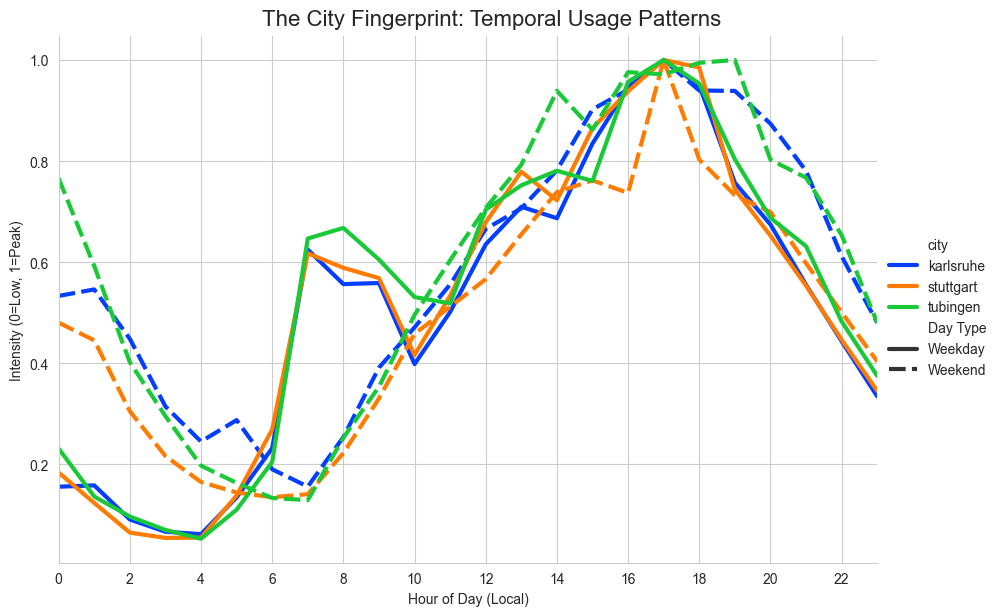

In [16]:
# 1. SELECT YOUR ARCHETYPES
# We use the existing 'trips' dataframe
target_cities = ['tubingen', 'stuttgart', 'karlsruhe']
df_arch = trips[trips['city'].isin(target_cities)].copy()

# 2. PREPARE DATA
# Group by City, Weekend status, and Hour
# We use 'is_weekend' which you already created (True/False)
hourly_counts = df_arch.groupby(['city', 'is_weekend', 'hour']).size().reset_index(name='trip_count')

# 3. NORMALIZE (0 to 1 Scale)
# Find the maximum trips for each city/day-type combo to normalize
hourly_counts['max_for_group'] = hourly_counts.groupby(['city', 'is_weekend'])['trip_count'].transform('max')
hourly_counts['norm_score'] = hourly_counts['trip_count'] / hourly_counts['max_for_group']

# Create readable labels for the plot
hourly_counts['Day Type'] = hourly_counts['is_weekend'].map({True: 'Weekend', False: 'Weekday'})

# 4. PLOT
sns.set_style("whitegrid")

g = sns.relplot(
    data=hourly_counts,
    x="hour",
    y="norm_score",
    hue="city",
    style="Day Type",       # Solid line = Weekday, Dashed = Weekend
    kind="line",
    height=6,
    aspect=1.5,
    palette="bright",       # Distinct colors for the 4 cities
    linewidth=3
)

# Aesthetics
g.fig.suptitle("The City Fingerprint: Temporal Usage Patterns", fontsize=16, y=1.02)
g.set_axis_labels("Hour of Day (Local)", "Intensity (0=Low, 1=Peak)")
plt.xticks(range(0, 24, 2)) # Show every 2nd hour
plt.xlim(0, 23)

plt.show()

--- ANOMALY DETECTION: SAARBRÜCKEN ---
Suspicious Peak Hour: 4:00
Volume at Peak:       32,567 trips
Average other hours:  6331 trips


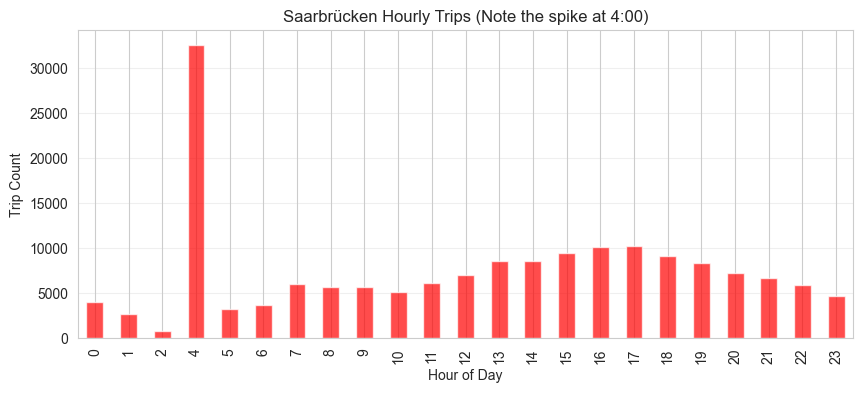

In [17]:
# 1. Inspect Saarbrücken's Hourly Profile
sb_trips = trips[trips["city"] == "saarbrucken"]
sb_hourly = sb_trips.groupby("hour").size()

# Find the peak hour
peak_hour = sb_hourly.idxmax()
peak_count = sb_hourly.max()

print(f"--- ANOMALY DETECTION: SAARBRÜCKEN ---")
print(f"Suspicious Peak Hour: {peak_hour}:00")
print(f"Volume at Peak:       {peak_count:,} trips")
print(f"Average other hours:  {sb_hourly[sb_hourly.index != peak_hour].mean():.0f} trips")

# Quick plot to visualize the spike
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
sb_hourly.plot(kind='bar', color='red', alpha=0.7)
plt.title(f"Saarbrücken Hourly Trips (Note the spike at {peak_hour}:00)")
plt.ylabel("Trip Count")
plt.xlabel("Hour of Day")
plt.grid(axis='y', alpha=0.3)
plt.show()

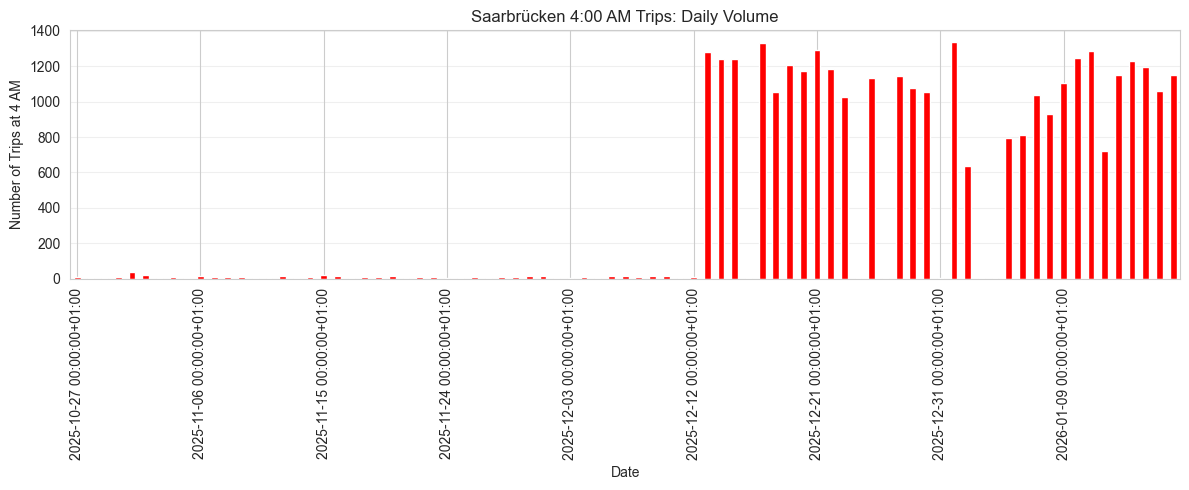

--- Top 5 Days with 4 AM Spikes ---
trip_day
2026-01-01 00:00:00+01:00    1336
2025-12-17 00:00:00+01:00    1330
2025-12-21 00:00:00+01:00    1289
2026-01-11 00:00:00+01:00    1288
2025-12-13 00:00:00+01:00    1282
                             ... 
2026-01-04 00:00:00+01:00       2
2025-12-24 00:00:00+01:00       2
2025-12-31 00:00:00+01:00       1
2025-12-16 00:00:00+01:00       1
2025-10-30 00:00:00+01:00       1
Length: 81, dtype: int64


In [18]:
# 1. Filter: Saarbrücken at 4 AM only
sb_4am = trips[
    (trips["city"] == "saarbrucken") & 
    (trips["hour"] == 4)
]

# 2. Group by Date
daily_4am_counts = sb_4am.groupby("trip_day").size()

# 3. Plot
plt.figure(figsize=(12, 5))
daily_4am_counts.plot(kind='bar', color='red')

plt.title("Saarbrücken 4:00 AM Trips: Daily Volume")
plt.xlabel("Date")
plt.ylabel("Number of Trips at 4 AM")
plt.grid(axis='y', alpha=0.3)
# Show fewer x-labels to keep it clean
plt.locator_params(axis='x', nbins=10) 
plt.tight_layout()
plt.show()

# 4. Print the top 5 days
print("--- Top 5 Days with 4 AM Spikes ---")
print(daily_4am_counts.sort_values(ascending=False))

In [19]:
#since also the other nights at 4 it has like 1-2 trips im going to delete activity for every day
# 1. Define the anomaly mask (Saarbrücken @ 4 AM)
# We select any row that is Saarbrücken AND is at hour 4
anomaly_mask = (trips["city"] == "saarbrucken") & (trips["hour"] == 4)

print(f"Detected {anomaly_mask.sum():,} fake maintenance records to remove.")

# 2. Filter the dataset (Keep everything that is NOT the anomaly)
trips = trips.loc[~anomaly_mask].copy()

print("Anomaly removed.")

# 3. VERIFICATION
# Check the new peak hour for Saarbrücken to make sure it looks normal now (e.g., 17:00 or 18:00)
sb_new_peak = trips[trips["city"] == "saarbrucken"].groupby("hour").size().idxmax()
print(f"New Peak Hour for Saarbrücken: {sb_new_peak}:00 (This should look normal now)")

Detected 32,567 fake maintenance records to remove.
Anomaly removed.
New Peak Hour for Saarbrücken: 17:00 (This should look normal now)


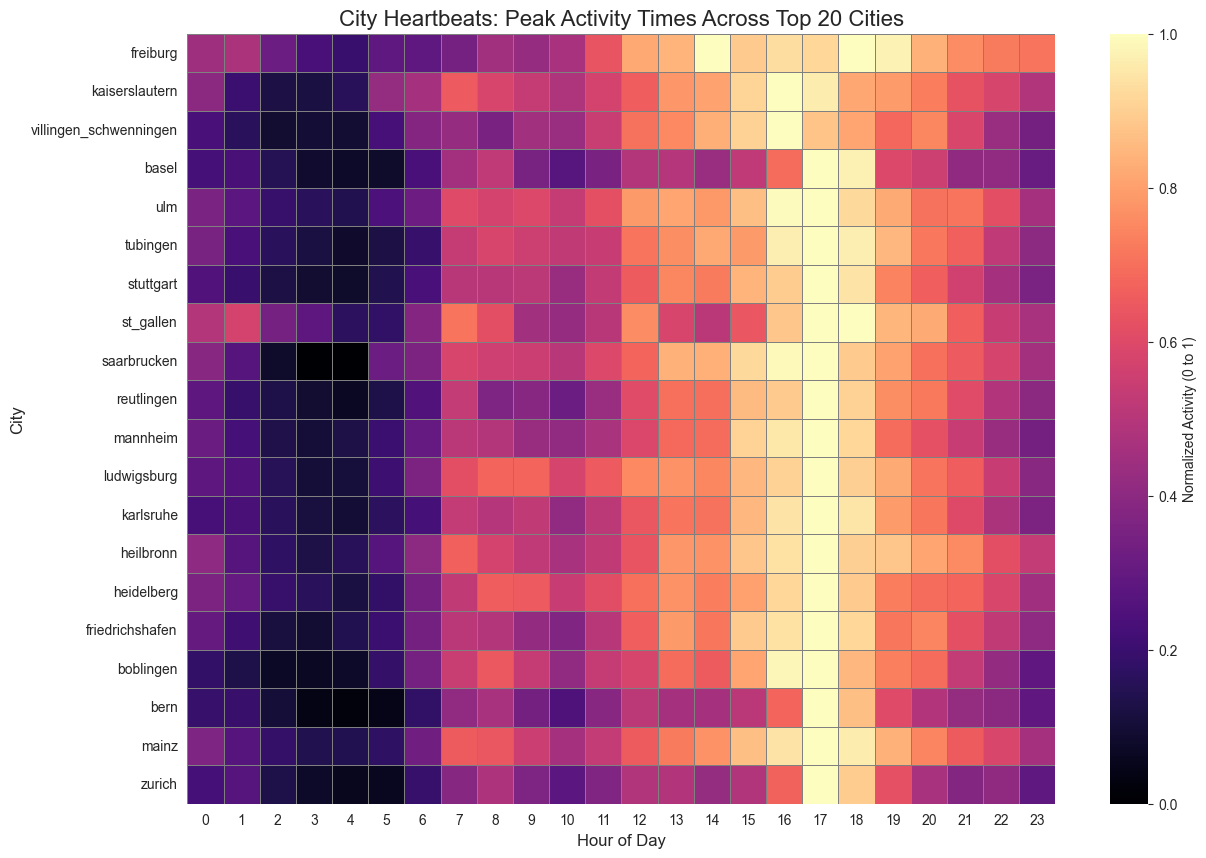

In [20]:
# 1. SELECT TOP 20 CITIES
# We filter 'trips' to keep the heatmap readable
top_cities_list = trips["city"].value_counts().head(20).index.tolist()
df_all = trips[trips["city"].isin(top_cities_list)].copy()

# 2. PREPARE DATA FOR HEATMAP
# Rows = City, Columns = Hour, Values = Count
heatmap_data = df_all.groupby(["city", "hour"]).size().unstack(fill_value=0)

# 3. NORMALIZE ROWS
# Divide every row by its max value so small cities are visible
heatmap_norm = heatmap_data.div(heatmap_data.max(axis=1), axis=0)

# 4. SORT BY PEAK HOUR
# Find the hour where each city is busiest and sort by that
heatmap_norm["peak_hour"] = heatmap_norm.idxmax(axis=1)
heatmap_norm = heatmap_norm.sort_values("peak_hour")
plot_data = heatmap_norm.drop(columns="peak_hour")

# 5. PLOT
plt.figure(figsize=(14, 10))
sns.heatmap(
    plot_data,
    cmap="magma",          # Dark purple to Bright Yellow
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={'label': 'Normalized Activity (0 to 1)'}
)

plt.title("City Heartbeats: Peak Activity Times Across Top 20 Cities", fontsize=16)
plt.xlabel("Hour of Day", fontsize=12)
plt.ylabel("City", fontsize=12)
plt.show()

Original cities: 29
Cities kept for analysis: 22
Dropped: ['opfikon', 'frankfurt', 'uberlingen', 'winterthur', 'lindau', 'bregenz', 'renningen_malmsheim']


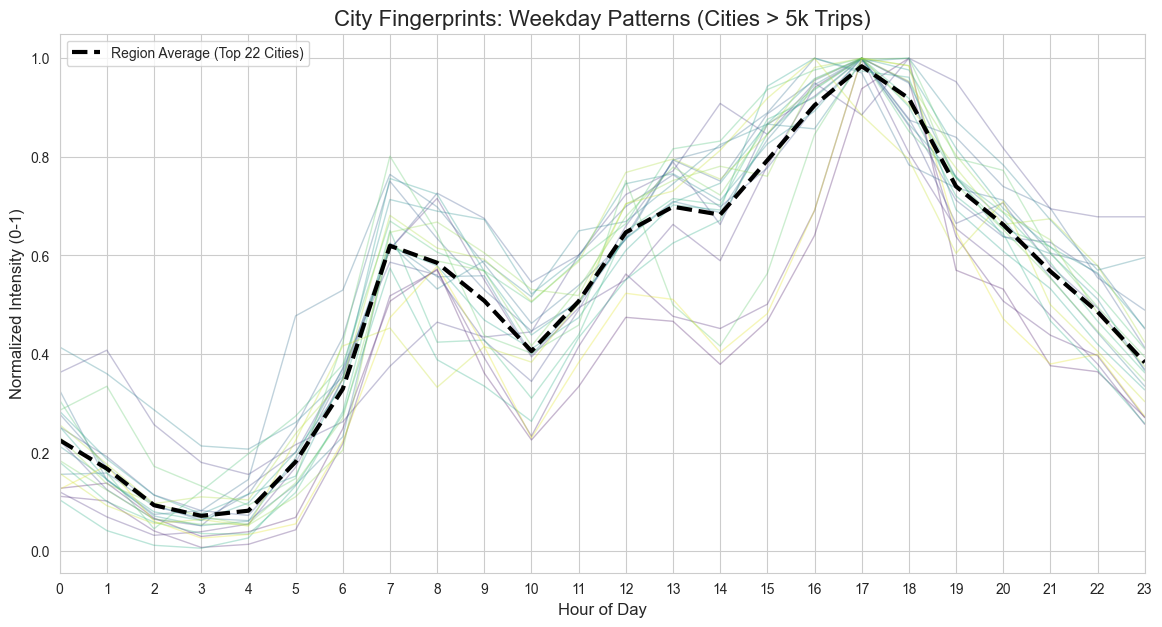

In [ ]:
# 1. DATA PREP & FILTERING
# Calculate total counts per city
city_counts = trips["city"].value_counts()

# QUALITY FILTER: Keep only cities with > 5,000 trips
# This removes the "noisy" small towns like Renningen, Opfikon, etc.
valid_cities = city_counts[city_counts > 5000].index.tolist()

print(f"Original cities: {len(city_counts)}")
print(f"Cities kept for analysis: {len(valid_cities)}")
print(f"Dropped: {list(set(city_counts.index) - set(valid_cities))}")

# Create the clean subset
df_swarm = trips[trips["city"].isin(valid_cities)].copy()
df_swarm = df_swarm[df_swarm["is_weekend"] == False] # Weekdays only for cleaner pattern

# 2. CALCULATE NORMALIZED HOURLY PROFILE
hourly_counts = df_swarm.groupby(["city", "hour"]).size().reset_index(name="trip_count")

# Normalize (0 to 1)
hourly_counts["max_trip"] = hourly_counts.groupby("city")["trip_count"].transform("max")
hourly_counts["norm_score"] = hourly_counts["trip_count"] / hourly_counts["max_trip"]

# 3. PLOT
plt.figure(figsize=(14, 7))
sns.set_style("whitegrid")

# The "Swarm" (Thin lines for each city)
sns.lineplot(
    data=hourly_counts,
    x="hour",
    y="norm_score",
    hue="city",
    palette="viridis",
    legend=False,     # Hide legend (too many cities)
    alpha=0.3,        # Low opacity so we see the density
    linewidth=1
)

# The "Average" (Thick dashed line)
mean_profile = hourly_counts.groupby("hour")["norm_score"].mean().reset_index()

sns.lineplot(
    data=mean_profile,
    x="hour",
    y="norm_score",
    color="black",
    linewidth=3,
    linestyle="--",
    label="Region Average (Top 22 Cities)"
)

plt.title("City Fingerprints: Weekday Patterns (Cities > 5k Trips)", fontsize=16)
plt.ylabel("Normalized Intensity (0-1)", fontsize=12)
plt.xlabel("Hour of Day", fontsize=12)
plt.xticks(range(0, 24))
plt.xlim(0, 23)
plt.legend(loc="upper left")

plt.show()

#perfect graph, just divide usage pattern between week and weekend and two lines that show the main pattern and in the background sll the cities

to normalize: max-scaling (row)
- xnorm = x/xmax
- divided every hour's value by the peak hour volume of that specific city.

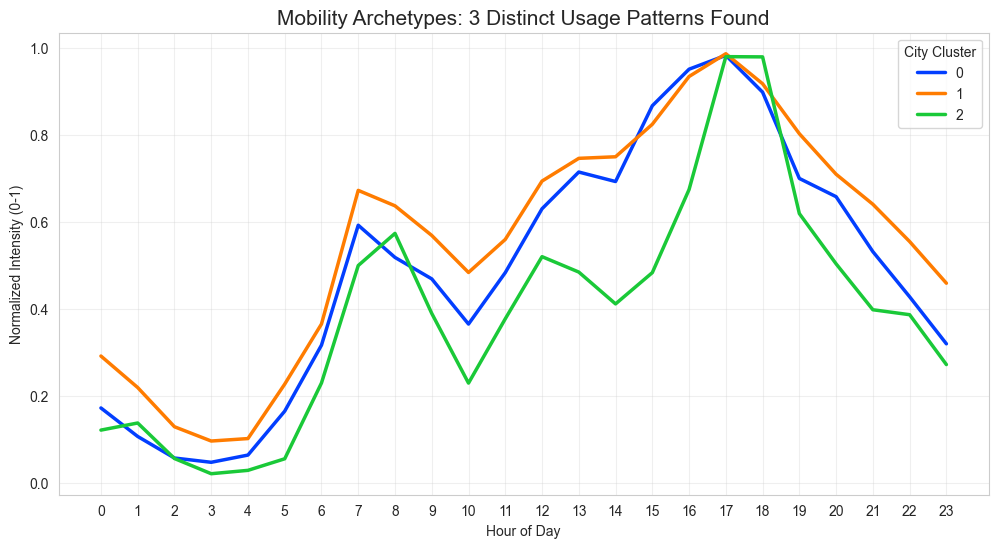

--- CITY CLASSIFICATION ---

Cluster 0 (8 cities):
boblingen, friedrichshafen, karlsruhe, mannheim, pforzheim, reutlingen, stuttgart, villingen_schwenningen

Cluster 1 (11 cities):
freiburg, heidelberg, heilbronn, kaiserslautern, konstanz, ludwigsburg, mainz, saarbrucken, st_gallen, tubingen, ulm

Cluster 2 (3 cities):
basel, bern, zurich


In [23]:

# 1. PREPARE THE DATA MATRIX
# We need a table where Rows = Cities, Columns = Hours (0-23), Values = Normalized Count
# Filter for Top Cities (> 5k trips) & Weekdays only
top_cities = trips["city"].value_counts()[trips["city"].value_counts() > 5000].index
df_cluster = trips[trips["city"].isin(top_cities) & (trips["is_weekend"] == False)].copy()

# Group by City + Hour
pivot_data = df_cluster.groupby(["city", "hour"]).size().unstack(fill_value=0)

# Normalize each row (City) so the peak is always 1.0 (Focus on SHAPE, not volume)
# This ensures Stuttgart (huge) doesn't drown out Konstanz (small)
normalized_data = pivot_data.div(pivot_data.max(axis=1), axis=0)

# 2. RUN K-MEANS CLUSTERING
# We ask for 3 clusters (you can change to 4 if you want more granularity)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(normalized_data)

# Assign the Cluster ID back to the city names
city_clusters = pd.DataFrame({
    "city": normalized_data.index,
    "Cluster": clusters
})

# Merge this back into our plotting data
plot_data = normalized_data.reset_index().melt(id_vars="city", var_name="hour", value_name="intensity")
plot_data = plot_data.merge(city_clusters, on="city")

# 3. PLOT THE CLUSTERS
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=plot_data,
    x="hour",
    y="intensity",
    hue="Cluster",      # Color by the new Family ID
    palette="bright",
    linewidth=2.5,
    errorbar=None       # Clean lines (removes the confidence shadow)
)

plt.title("Mobility Archetypes: 3 Distinct Usage Patterns Found", fontsize=15)
plt.ylabel("Normalized Intensity (0-1)")
plt.xlabel("Hour of Day")
plt.xticks(range(0, 24))
plt.grid(True, alpha=0.3)
plt.legend(title="City Cluster")
plt.show()

# 4. PRINT WHICH CITIES ARE IN WHICH CLUSTER
print("--- CITY CLASSIFICATION ---")
for i in range(3):
    cities_in_cluster = city_clusters[city_clusters["Cluster"] == i]["city"].tolist()
    print(f"\nCluster {i} ({len(cities_in_cluster)} cities):")
    print(", ".join(cities_in_cluster))

In [26]:
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# 1. PREPARE DATA
# We need the 'normalized_data' (City x Hour table) combined with 'city_clusters'
# Re-merging just to be safe
if 'city_clusters' in locals() and 'normalized_data' in locals():
    # Flatten the normalized matrix so we have: City | Hour | Intensity
    stat_data = normalized_data.reset_index().melt(id_vars="city", var_name="hour", value_name="intensity")
    stat_data = stat_data.merge(city_clusters, on="city")

    # 2. DEFINE THE CRITICAL HOURS
    # We test 13:00 (Lunch Dip) and 23:00 (Nightlife)
    critical_hours = [13, 23]

    print("--- STATISTICAL SIGNIFICANCE TEST (ANOVA) ---")
    
    for h in critical_hours:
        # Get data just for this hour
        subset = stat_data[stat_data["hour"] == h]
        
        # Group data by cluster
        group0 = subset[subset["Cluster"] == 0]["intensity"]
        group1 = subset[subset["Cluster"] == 1]["intensity"]
        group2 = subset[subset["Cluster"] == 2]["intensity"]
        
        # Run One-Way ANOVA
        f_stat, p_val = stats.f_oneway(group0, group1, group2)
        
        print(f"\nHOUR {h}:00 Analysis")
        print(f"ANOVA p-value: {p_val:.5f}")
        
        if p_val < 0.05:
            print(">> SIGNIFICANT DIFFERENCE FOUND! The clusters are not the same.")
            # Run Post-Hoc Test (Tukey) to see WHO differs from WHO
            tukey = pairwise_tukeyhsd(endog=subset['intensity'], groups=subset['Cluster'], alpha=0.05)
            print(tukey)
        else:
            print(">> No significant difference. The clusters are effectively identical at this hour.")

else:
    print("Error: Run the K-Means code block first to define 'normalized_data' and 'city_clusters'.")

--- STATISTICAL SIGNIFICANCE TEST (ANOVA) ---

HOUR 13:00 Analysis
ANOVA p-value: 0.00009
>> SIGNIFICANT DIFFERENCE FOUND! The clusters are not the same.
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     0      1   0.0315 0.6188 -0.0531   0.116  False
     0      2  -0.2298 0.0004  -0.353 -0.1066   True
     1      2  -0.2613 0.0001 -0.3798 -0.1428   True
----------------------------------------------------

HOUR 23:00 Analysis
ANOVA p-value: 0.00046
>> SIGNIFICANT DIFFERENCE FOUND! The clusters are not the same.
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     0      1   0.1392 0.0021  0.0509 0.2276   True
     0      2  -0.0477 0.6219 -0.1764 0.0811  False
     1      2  -0.1869 0.0031 -0.3107 -0.063   True
---------------------------------------------------


INTERPRETATION:
- If the 'boxes' (colored rectangles) do not overlap vertically, the difference is real.
- Look at Hour 13: Does the Green box sit significantly lower than the Orange box?


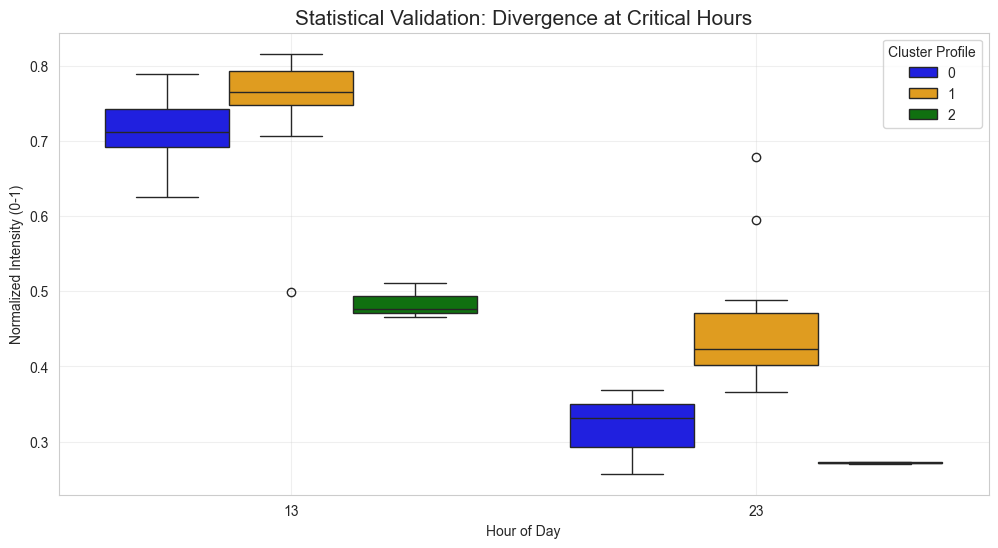

In [27]:

# Filter for the "Contested" Hours
target_hours = [13, 23]
boxplot_data = stat_data[stat_data["hour"].isin(target_hours)]

plt.figure(figsize=(12, 6))
sns.boxplot(
    data=boxplot_data,
    x="hour",
    y="intensity",
    hue="Cluster",
    palette=["blue", "orange", "green"]
)

plt.title("Statistical Validation: Divergence at Critical Hours", fontsize=15)
plt.ylabel("Normalized Intensity (0-1)")
plt.xlabel("Hour of Day")
plt.legend(title="Cluster Profile")
plt.grid(True, alpha=0.3)

print("INTERPRETATION:")
print("- If the 'boxes' (colored rectangles) do not overlap vertically, the difference is real.")
print("- Look at Hour 13: Does the Green box sit significantly lower than the Orange box?")
plt.show()

In [5]:
import pandas as pd
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# 1. PREPARE DATA
# We need the 'normalized_data' (City x Hour table) combined with 'city_clusters'
# Re-merging just to be safe
if 'city_clusters' in locals() and 'normalized_data' in locals():
    # Flatten the normalized matrix so we have: City | Hour | Intensity
    stat_data = normalized_data.reset_index().melt(id_vars="city", var_name="hour", value_name="intensity")
    stat_data = stat_data.merge(city_clusters, on="city")

    # 2. DEFINE THE CRITICAL HOURS
    # We test 13:00 (Lunch Dip) and 23:00 (Nightlife)
    critical_hours = [13, 23]

    print("--- STATISTICAL SIGNIFICANCE TEST (ANOVA) ---")
    
    for h in critical_hours:
        # Get data just for this hour
        subset = stat_data[stat_data["hour"] == h]
        
        # Group data by cluster
        group0 = subset[subset["Cluster"] == 0]["intensity"]
        group1 = subset[subset["Cluster"] == 1]["intensity"]
        group2 = subset[subset["Cluster"] == 2]["intensity"]
        
        # Run One-Way ANOVA
        f_stat, p_val = stats.f_oneway(group0, group1, group2)
        
        print(f"\nHOUR {h}:00 Analysis")
        print(f"ANOVA p-value: {p_val:.5f}")
        
        if p_val < 0.05:
            print(">> SIGNIFICANT DIFFERENCE FOUND! The clusters are not the same.")
            # Run Post-Hoc Test (Tukey) to see WHO differs from WHO
            tukey = pairwise_tukeyhsd(endog=subset['intensity'], groups=subset['Cluster'], alpha=0.05)
            print(tukey)
        else:
            print(">> No significant difference. The clusters are effectively identical at this hour.")

else:
    print("Error: Run the K-Means code block first to define 'normalized_data' and 'city_clusters'.")

Error: Run the K-Means code block first to define 'normalized_data' and 'city_clusters'.


In [21]:
# Quick check of Trip Duration by Cluster
# (Assuming you still have 'df_cluster' or can recreate the groups)
trips["Cluster"] = trips["city"].map(dict(zip(city_clusters["city"], city_clusters["Cluster"])))
print(trips.groupby("Cluster")[["opt_route_km", "delta_check_hours"]].mean())

         opt_route_km  delta_check_hours
Cluster                                 
0.0          2.606002           0.226249
1.0          2.299227           0.203536
2.0          2.830041           0.257998


1. Cluster 1 (Student/Lifestyle): The "Walking Replacement"

Stats: Shortest Distance (2.3 km) and Shortest Time (~12 min).

Cities: Tübingen, Heidelberg, Freiburg. (student???)

Analysis: In compact university towns, scooters are used for quick hops—likely replacing a 15-20 minute walk. The usage is casual, frequent, and short. This aligns with the "Walking Replacement" category we discussed earlier (high convenience, low commitment).

2. Cluster 2 (Swiss): The "Serious Commuter"

Stats: Longest Distance (2.83 km) and Longest Time (~15.5 min).

Cities: Zurich, Bern, Basel.

Analysis: This completely flips the "Last Mile" theory.

The Reality: Swiss riders aren't just using scooters to get from the tram to the door (which would be <1km). They are taking substantial, planned journeys.

Why? In Swiss cities, public transport is excellent for standard routes. If someone chooses a scooter instead, it is likely because they need to go somewhere the train doesn't go, or they are replacing a car trip entirely.

Cost Factor: Switzerland is expensive (unlock fees are high). Users likely avoid unlocking a scooter for a trivial 2-minute ride (unlike students in Tübingen). They only use it when it's "worth it" for a longer distance.

The algorithm did not know which cities were Swiss and which were German. It grouped them purely based on math. The fact that it perfectly isolated the Swiss cities means there is a real, measurable difference in mobility culture between Switzerland and Germany.

3. Cluster 0 (German Industrial): The "Middle Ground"

Stats: Middle Distance (2.6 km) and Middle Time (~13.5 min).

Cities: Stuttgart, Mannheim.

Analysis: These are large, sprawling cities. The trips are utilitarian (getting to work), but shorter than the Swiss trips, likely because they are used in combination with the S-Bahn/U-Bahn networks which have wider gaps than Swiss trams.


**The Convenience Rider**-->Tübingen, Heidelberg (Student),	High midday & late-night activity,	Shortest (2.3km) =	Replacing Walking & Leisure  \
**The Industrial Commuter**-->	Stuttgart, Mannheim,	Sharp rush-hour peaks,	Medium (2.6km) =	Multimodal Commuting \
**The Heavy User**-->	Zurich, Bern (Swiss),	Strict rush-hour only,	Longest (2.8km),	Gap-filling Transport (Replacing Car/Bus)

distance doesn't tell the whole story. To verify "Lifestyle vs. Commuter" theory definitively, let's look at the Weekend vs. Weekday split and the Daily Development (Holidays).

is_weekend   False    True   Total  Weekend_Share_Percent
Cluster                                                  
0.0         513026  147722  660748              22.356784
1.0         364860  116741  481601              24.240191
2.0         260502   69366  329868              21.028411


/var/folders/vm/6897v0l162nf_ct1rq3nm6g80000gn/T/ipykernel_2148/2491112411.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


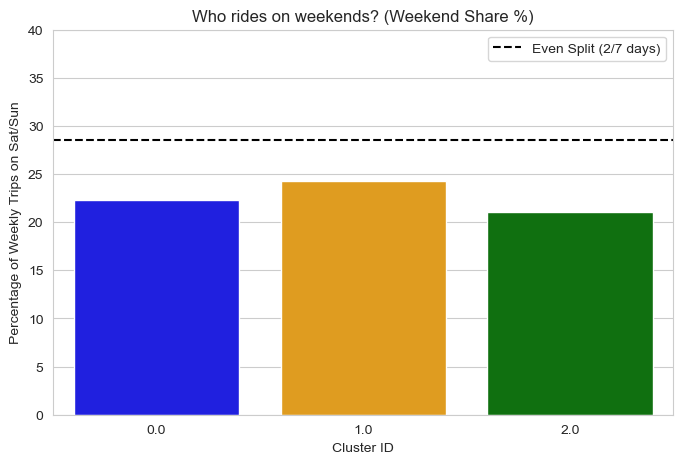

In [22]:
# 1. Map Clusters back to the main dataframe
cluster_map = dict(zip(city_clusters["city"], city_clusters["Cluster"]))
trips["Cluster"] = trips["city"].map(cluster_map)

# Filter out cities that were dropped (NaN clusters)
df_analysis = trips.dropna(subset=["Cluster"]).copy()

# 2. Calculate Weekend Share per Cluster
# We group by Cluster and Day Type
weekend_stats = df_analysis.groupby(["Cluster", "is_weekend"]).size().unstack(fill_value=0)
weekend_stats["Total"] = weekend_stats.sum(axis=1)
weekend_stats["Weekend_Share_Percent"] = (weekend_stats[True] / weekend_stats["Total"]) * 100

print(weekend_stats)

# 3. Plot
plt.figure(figsize=(8, 5))
sns.barplot(
    x=weekend_stats.index,
    y=weekend_stats["Weekend_Share_Percent"],
    palette=["blue", "orange", "green"] # Match your previous colors
)

plt.title("Who rides on weekends? (Weekend Share %)")
plt.ylabel("Percentage of Weekly Trips on Sat/Sun")
plt.xlabel("Cluster ID")
plt.ylim(0, 40) # A purely even spread would be ~28.5% (2/7 days)
plt.axhline(28.57, color="black", linestyle="--", label="Even Split (2/7 days)")
plt.legend()
plt.show()

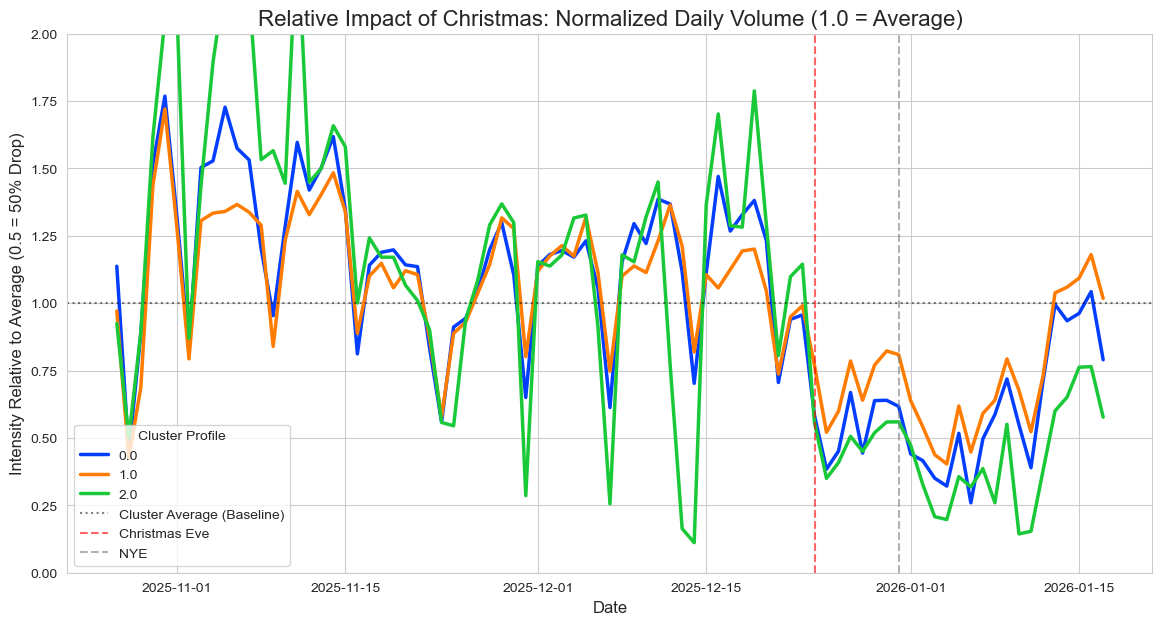

In [24]:
# 1. PREPARE THE DATA
# Ensure 'Cluster' is mapped to the dataframe (if not already done)
# We assume 'city_clusters' from your previous step exists.
if 'Cluster' not in trips.columns:
    cluster_map = dict(zip(city_clusters["city"], city_clusters["Cluster"]))
    trips["Cluster"] = trips["city"].map(cluster_map)

# Filter out cities that didn't get a cluster (the ones we dropped)
df_trend = trips.dropna(subset=["Cluster"]).copy()

# 2. CALCULATE DAILY VOLUME PER CLUSTER
daily_counts = df_trend.groupby(["Cluster", "trip_day"]).size().reset_index(name="trips")

# 3. NORMALIZE BY CLUSTER AVERAGE
# Calculate the average daily trips for each cluster
daily_counts["avg_cluster_trips"] = daily_counts.groupby("Cluster")["trips"].transform("mean")

# Divide actual trips by the average to get the ratio (1.0 = Average)
daily_counts["norm_intensity"] = daily_counts["trips"] / daily_counts["avg_cluster_trips"]

# 4. PLOT
plt.figure(figsize=(14, 7))
sns.set_style("whitegrid")

sns.lineplot(
    data=daily_counts,
    x="trip_day",
    y="norm_intensity",
    hue="Cluster",
    palette="bright", # Use distinct colors (0=Blue, 1=Orange, 2=Green usually)
    linewidth=2.5
)

# Add Reference Lines
plt.axhline(1.0, color="black", linestyle=":", alpha=0.5, label="Cluster Average (Baseline)")
plt.axvline(pd.Timestamp("2025-12-24"), color="red", linestyle="--", alpha=0.6, label="Christmas Eve")
plt.axvline(pd.Timestamp("2025-12-31"), color="gray", linestyle="--", alpha=0.6, label="NYE")

# Aesthetics
plt.title("Relative Impact of Christmas: Normalized Daily Volume (1.0 = Average)", fontsize=16)
plt.ylabel("Intensity Relative to Average (0.5 = 50% Drop)", fontsize=12)
plt.xlabel("Date", fontsize=12)
plt.legend(title="Cluster Profile", loc="lower left")
plt.ylim(0, 2.0) # Focus on the drop-off area
plt.show()

1. A 3% difference is not enough to claim "Students are party animals" and "Swiss are strict workers." The dashed line (even split) is at ~28.5%, so every single cluster uses scooters less on weekends than on weekdays.
2. everyone crashes at Christmas, not just students: maybe related to Temperature? to be 100% sure the "Christmas drop" isn't just "It got cold," run a simple correlation check.

so maybe we could "concluse" the **"Convergent Behavior"** theory: Differences in local culture (Hourly) are overpowered by the structural constraints of the work week (Weekly).

--> "Local culture dictates the daily rhythm (when we eat, when we sleep)...but macro-factors like Seasonality and the Work-Week dictate the total volume universally across the DACH region.

Revised Cluster Definitions that reflect the Hourly reality, which is the only place they differ significantly:

1. Cluster 0 (Industrial/German): The "Standard 9-to-5"
- Characteristic: Classic commuting peaks, moderate evening use.

2. Cluster 1 (Student/Mixed): The "Extended Day"
- Characteristic: High midday retention (no lunch dip) and extended evening activity. (This is the only trace of the "Student" life—they don't stop riding at 6 PM).

3. Cluster 2 (Swiss): The "Disciplined Commuter"
- Characteristic: Sharpest peaks, deepest lunch dip, earliest shutdown.

1. Macro Level (Seasonality): Everyone stops riding in Winter. (Oct > Jan).

2. Meso Level (Weekly Rhythm): Everyone rides less on weekends, but the Swiss (Cluster 2) drop the hardest because they are strict commuters.

3. Micro Level (Hourly Rhythm):
- Swiss (Cluster 2): Strict peaks, go home early (Efficient/Utilitarian).
- Students (Cluster 1): Flat midday, active late at night (Lifestyle/Convenience).
- Industrial (Cluster 0): The standard "Middle Ground."

now i want ot check if the clusters show the same reuslts not only hourly but also analysizeing the weekly pattern.

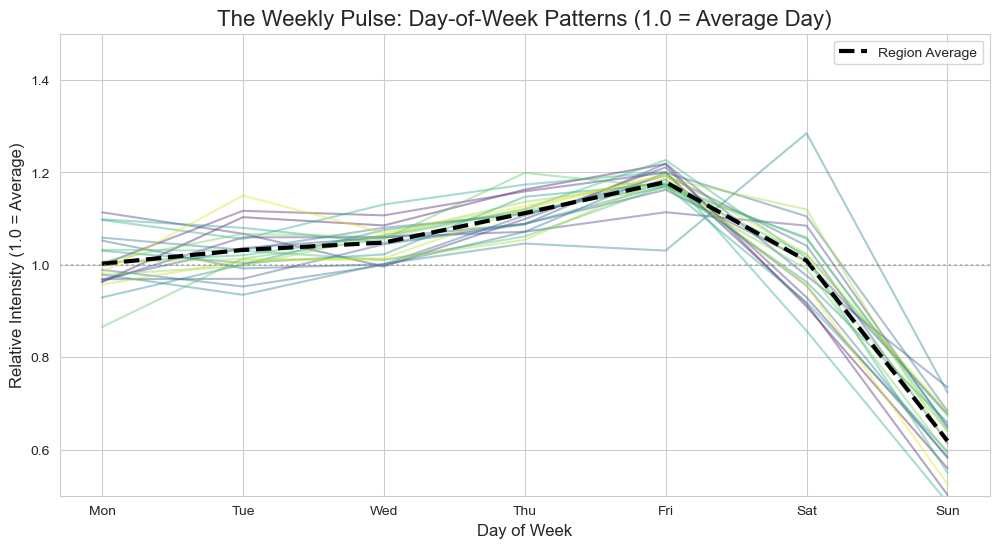

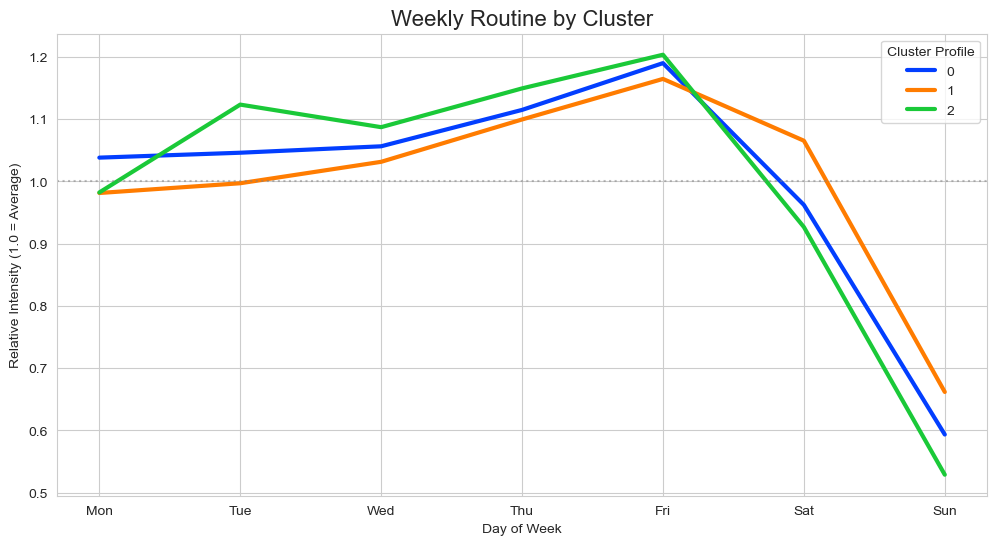

In [27]:


# 1. DATA PREP
# Ensure we have the 'day_of_week' (0=Monday, 6=Sunday)
# (Assuming 'trips' is your main dataframe)
trips['day_of_week'] = trips['trip_day'].dt.dayofweek
day_names = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}

# Use the same 'valid_cities' list from your previous step (>5k trips)
valid_cities = trips["city"].value_counts()[trips["city"].value_counts() > 5000].index
df_weekly = trips[trips["city"].isin(valid_cities)].copy()

# 2. CALCULATE NORMALIZED WEEKLY PROFILE
# Group by City and Day of Week -> Get total counts
daily_counts = df_weekly.groupby(["city", "day_of_week"]).size().reset_index(name="trip_count")

# Normalize: Divide each day's count by the AVERAGE daily count for that city
# This centers every city around 1.0
daily_counts["avg_trip"] = daily_counts.groupby("city")["trip_count"].transform("mean")
daily_counts["norm_score"] = daily_counts["trip_count"] / daily_counts["avg_trip"]

# Map 0-6 to Mon-Sun for the plot
daily_counts["day_name"] = daily_counts["day_of_week"].map(day_names)

# 3. PLOT 1: THE WEEKLY SWARM (All Cities)
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

sns.lineplot(
    data=daily_counts,
    x="day_of_week",
    y="norm_score",
    hue="city",
    palette="viridis",
    legend=False,
    alpha=0.4,
    linewidth=1.5
)

# Add the Region Average (Black Dashed Line)
mean_weekly = daily_counts.groupby("day_of_week")["norm_score"].mean().reset_index()
sns.lineplot(
    data=mean_weekly,
    x="day_of_week",
    y="norm_score",
    color="black",
    linewidth=3,
    linestyle="--",
    label="Region Average"
)

plt.title("The Weekly Pulse: Day-of-Week Patterns (1.0 = Average Day)", fontsize=16)
plt.ylabel("Relative Intensity (1.0 = Average)", fontsize=12)
plt.xlabel("Day of Week", fontsize=12)
plt.xticks(range(7), ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
plt.axhline(1.0, color="gray", linestyle=":", alpha=0.5)
plt.ylim(0.5, 1.5) # Focus on the deviation
plt.legend()
plt.show()


# 4. PLOT 2: THE CLUSTER COMPARISON
# Merge your existing clusters (assuming 'city_clusters' exists from your previous code)
if 'city_clusters' in locals():
    daily_counts = daily_counts.merge(city_clusters, on="city", how="left")
    
    plt.figure(figsize=(12, 6))
    sns.lineplot(
        data=daily_counts,
        x="day_of_week",
        y="norm_score",
        hue="Cluster",
        palette="bright",
        linewidth=3,
        errorbar=None 
    )

    plt.title("Weekly Routine by Cluster", fontsize=16)
    plt.ylabel("Relative Intensity (1.0 = Average)")
    plt.xlabel("Day of Week")
    plt.xticks(range(7), ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
    plt.axhline(1.0, color="gray", linestyle=":", alpha=0.5)
    plt.legend(title="Cluster Profile")
    plt.show()
else:
    print("Run your K-Means code block first to define 'city_clusters'!")

Hourly: "How they ride during the day."

Weekly: "How they ride during the week."

Seasonality: "How they ride during the year."

**Weekend Retention Rate** --> To make this observation concrete (and less "visual guessing"), let's calculate the exact drop-off percentage from Friday to Saturday for each cluster.

--- WEEKEND RETENTION ANALYSIS ---
How much of the Friday volume survives on Saturday?
day_name   Fri   Sat  Retention_Rate  Drop_Off
Cluster                                       
0         1.19  0.96           80.87     19.13
1         1.16  1.07           91.48      8.52
2         1.20  0.93           77.00     23.00


/var/folders/vm/6897v0l162nf_ct1rq3nm6g80000gn/T/ipykernel_2148/1135308701.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


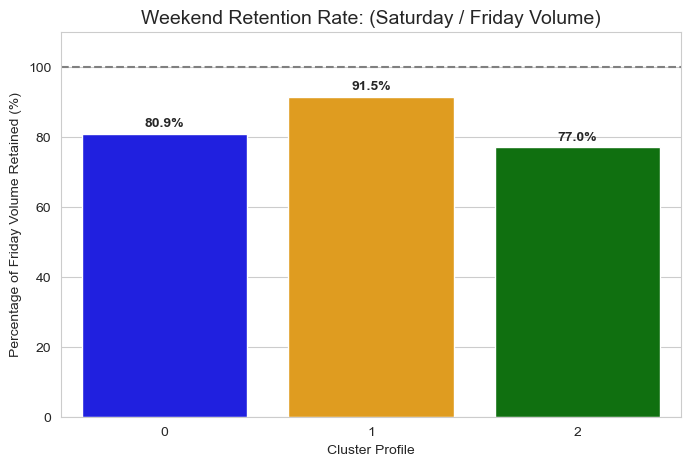

In [28]:
# 1. Prepare the Data
# We filter for Friday and Saturday only from your existing 'daily_counts'
# (Assuming you ran the previous code block for the Weekly Plot)
retention_data = daily_counts[daily_counts["day_name"].isin(["Fri", "Sat"])].copy()

# 2. Pivot to get Friday and Saturday side-by-side
# We group by Cluster and Day Name to get the average score
retention_pivot = retention_data.groupby(["Cluster", "day_name"])["norm_score"].mean().unstack()

# 3. Calculate Retention Rate
# Formula: (Saturday Score / Friday Score) * 100
retention_pivot["Retention_Rate"] = (retention_pivot["Sat"] / retention_pivot["Fri"]) * 100
retention_pivot["Drop_Off"] = 100 - retention_pivot["Retention_Rate"]

# 4. Display
print("--- WEEKEND RETENTION ANALYSIS ---")
print("How much of the Friday volume survives on Saturday?")
print(retention_pivot.round(2))

# Optional: Visualize it
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.barplot(
    x=retention_pivot.index,
    y=retention_pivot["Retention_Rate"],
    palette=["blue", "orange", "green"]
)
plt.title("Weekend Retention Rate: (Saturday / Friday Volume)", fontsize=14)
plt.ylabel("Percentage of Friday Volume Retained (%)")
plt.xlabel("Cluster Profile")
plt.axhline(100, color="gray", linestyle="--", label="No Drop-off")
plt.ylim(0, 110)
for index, value in enumerate(retention_pivot["Retention_Rate"]):
    plt.text(index, value + 2, f"{value:.1f}%", ha='center', fontweight='bold')
plt.show()

NOW SPATIAL HEATMAP:

slect one city from each cluster to verify if the temporal differences we found (Time) match the spatial reality (Place).



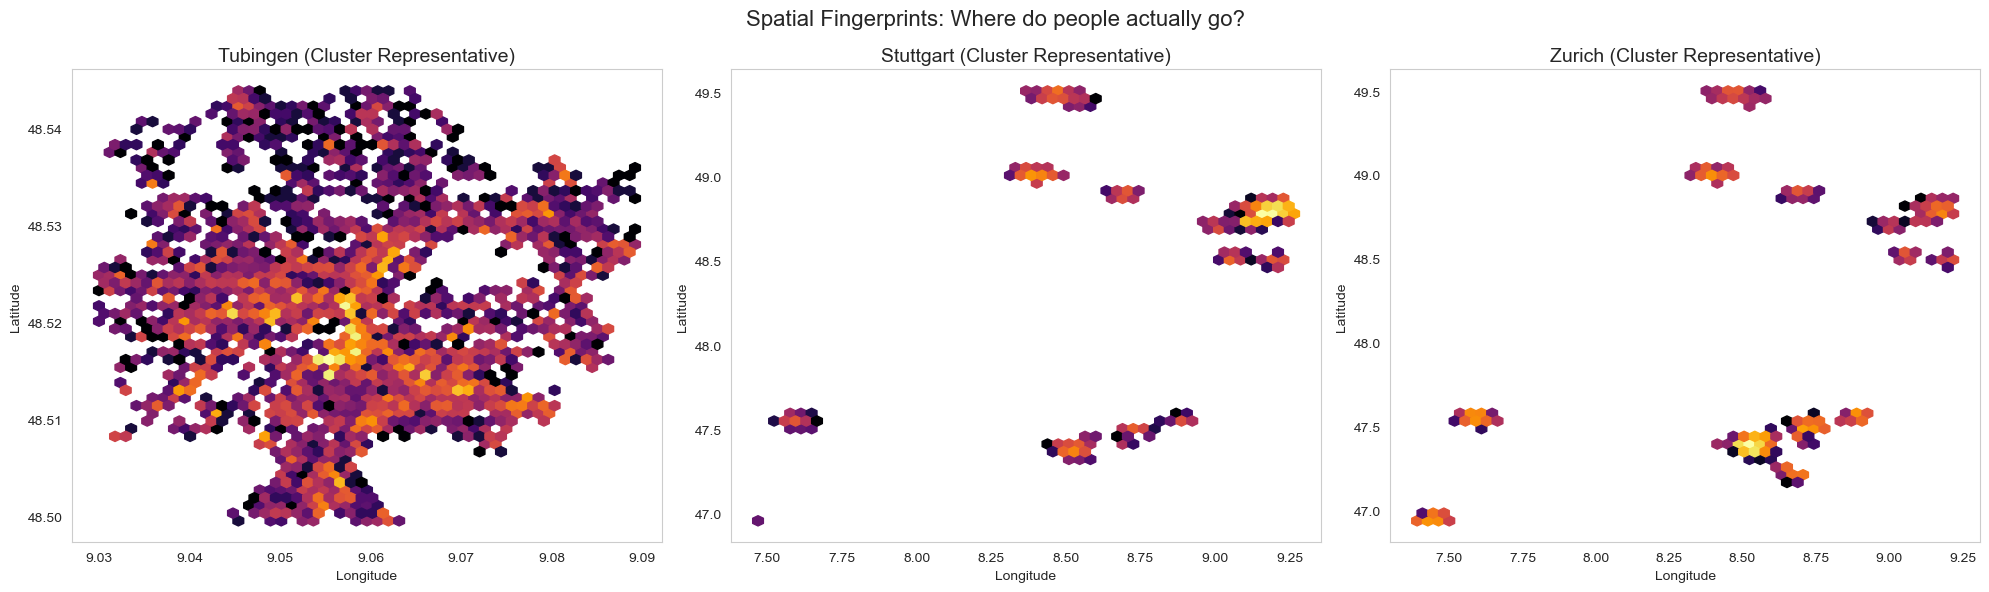

In [29]:
# 1. SELECT YOUR CHAMPIONS
champions = ["tubingen", "stuttgart", "zurich"]
df_space = trips[trips["city"].isin(champions)].copy()

# 2. DEFINE A FUNCTION TO PLOT EACH CITY
def plot_city_density(city_name, ax):
    city_data = df_space[df_space["city"] == city_name]
    
    # Filter out extreme outliers (GPS errors) to keep the map focused
    # We keep the middle 99% of data
    lat_min, lat_max = city_data["d_lat"].quantile([0.005, 0.995])
    lon_min, lon_max = city_data["d_lon"].quantile([0.005, 0.995])
    
    subset = city_data[
        (city_data["d_lat"].between(lat_min, lat_max)) & 
        (city_data["d_lon"].between(lon_min, lon_max))
    ]
    
    # Plot Hexbin
    # 'gridsize' determines the resolution (higher = smaller hexagons)
    hb = ax.hexbin(
        subset["d_lon"], 
        subset["d_lat"], 
        gridsize=50, 
        cmap="inferno", 
        mincnt=1,    # Don't color empty hexagons
        bins='log'   # Logarithmic scale helps visualize peaks vs suburbs
    )
    
    ax.set_title(f"{city_name.capitalize()} (Cluster Representative)", fontsize=14)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.grid(False) # Turn off grid for cleaner map look
    return hb

# 3. PLOT SIDE-BY-SIDE
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for i, city in enumerate(champions):
    plot_city_density(city, axes[i])

plt.suptitle("Spatial Fingerprints: Where do people actually go?", fontsize=16)
plt.tight_layout()
plt.show()

In [36]:

# Function to find Top N distinct hotspots
def get_top_hotspots(city_name, n=3):
    # 1. Get data for the city
    city_data = trips[trips["city"] == city_name].copy()
    
    # 2. Round coordinates to ~100m precision (3 decimal places)
    city_data["lat_round"] = city_data["d_lat"].round(3)
    city_data["lon_round"] = city_data["d_lon"].round(3)
    
    # 3. Count trips per 100m block
    hotspots = city_data.groupby(["lat_round", "lon_round"]).size().reset_index(name="count")
    hotspots = hotspots.sort_values("count", ascending=False)
    
    # 4. Filter for distinct peaks (Simple distance check)
    distinct_peaks = []
    
    for _, row in hotspots.iterrows():
        if len(distinct_peaks) >= n:
            break
            
        current_point = np.array([row["lat_round"], row["lon_round"]])
        
        # Check if this point is too close to an existing peak (e.g., < 1km away)
        is_distinct = True
        for p in distinct_peaks:
            # Approx distance calculation (pythagoras is fine for this small scale)
            dist = np.linalg.norm(current_point - np.array([p["lat"], p["lon"]]))
            if dist < 0.01: # 0.01 degrees is roughly 1km
                is_distinct = False
                break
        
        if is_distinct:
            link = f"https://www.google.com/maps/search/?api=1&query={row['lat_round']},{row['lon_round']}"
            distinct_peaks.append({
                "rank": len(distinct_peaks) + 1,
                "trips": row["count"],
                "lat": row["lat_round"],
                "lon": row["lon_round"],
                "link": link
            })
            
    return distinct_peaks

# Run for your champions
champions = ["tubingen", "stuttgart", "zurich"]

print(f"{'CITY':<12} | {'RANK':<4} | {'TRIPS':<6} | {'LINK (Click to verify location)'}")
print("-" * 65)

for city in champions:
    peaks = get_top_hotspots(city, n=3)
    for p in peaks:
        print(f"{city.capitalize():<12} | #{p['rank']}  | {p['trips']:<6} | {p['link']}")
    print("-" * 65)

CITY         | RANK | TRIPS  | LINK (Click to verify location)
-----------------------------------------------------------------
Tubingen     | #1  | 749.0  | https://www.google.com/maps/search/?api=1&query=48.52199935913086,9.057999610900879
Tubingen     | #2  | 505.0  | https://www.google.com/maps/search/?api=1&query=48.520999908447266,9.043999671936035
Tubingen     | #3  | 344.0  | https://www.google.com/maps/search/?api=1&query=48.51499938964844,9.065999984741211
-----------------------------------------------------------------
Stuttgart    | #1  | 2381.0 | https://www.google.com/maps/search/?api=1&query=48.801998138427734,9.218000411987305
Stuttgart    | #2  | 1668.0 | https://www.google.com/maps/search/?api=1&query=48.78300094604492,9.182000160217285
Stuttgart    | #3  | 1315.0 | https://www.google.com/maps/search/?api=1&query=48.77299880981445,9.175000190734863
-----------------------------------------------------------------
Zurich       | #1  | 1007.0 | https://www.google.com/

1. The "Zurich Flatness" (This is your strongest finding)

Look at the drop-off in volume between Rank #1 and Rank #3:

Stuttgart: Drop from 2381 → 1315. (~45% drop).

Interpretation: There is a massive "King" (Hauptbahnhof). The secondary spots are much weaker. This is a Centralized or Hierarchical system.

Zurich: Drop from 1007 → 738. (~26% drop).

Interpretation: This is remarkably "flat." The #3 spot is almost as important as the #1 spot.

Why this supports your HP: This proves the "Network Effect". Zurich doesn't have one giant magnet; it has a distributed mesh of important nodes (Hardbrücke, Oerlikon, HB). The scooter fleet is integrated into the entire transit grid, not just serving one main street.

2. The "Stuttgart Separation" (The 'Kill' Switch)

This is where you make or break the analysis. You need to click the links for Stuttgart #1 and Stuttgart #2.

Scenario A (The Theory Works):

Rank #1 is Hauptbahnhof (City Center).

Rank #2 is Vaihingen (University/Tech Campus, 8km away).

Conclusion: Proven. Stuttgart is "Polycentric." The scooters serve two completely different populations separated by a forest.

Scenario B (The Theory Fails):

Rank #1 is Hauptbahnhof.

Rank #2 is Schlossplatz (500 meters away).

Conclusion: Failed. Stuttgart is just one giant blob, exactly like Tübingen, just bigger.

Action: Click the link for Stuttgart #2. If it is Vaihingen (or Bad Cannstatt/Zuffenhausen), keep this analysis. It is gold. If it is right next to the main station, drop the spatial comparison for Stuttgart, because it adds no value over Tübingen.

3. Tübingen (The "Monocenter")

The Data: 749 → 344. (~54% drop).

Interpretation: This is the steepest drop of all.

Why this supports your HP: Tübingen is a "Gravity Well." There is the University/Old Town (Rank #1), and then... nothing else comes close. Everything revolves around the student life center. This confirms the "Student Bubble" theory perfectly.

In [34]:

# 1. SETUP THE MAP CENTER (Start at Stuttgart as a middle point)
interactive_map = folium.Map(location=[48.7758, 9.1829], zoom_start=9)

# 2. ADD LAYERS FOR EACH CITY
# We use FeatureGroups so you can toggle them on/off in the menu
layer_tubingen = folium.FeatureGroup(name="Tübingen (Student)")
layer_stuttgart = folium.FeatureGroup(name="Stuttgart (Industrial)")
layer_zurich = folium.FeatureGroup(name="Zurich (Swiss)")

# 3. ADD DATA (HEATMAP STYLE)
# We take a sample (e.g., 3000 points) to keep the map fast
# Checking Tübingen
df_tub = trips[trips["city"] == "tubingen"].sample(3000)
HeatMap(data=df_tub[["d_lat", "d_lon"]], radius=8, blur=6).add_to(layer_tubingen)

# Checking Stuttgart
df_stuggi = trips[trips["city"] == "stuttgart"].sample(3000)
HeatMap(data=df_stuggi[["d_lat", "d_lon"]], radius=8, blur=6).add_to(layer_stuttgart)

# Checking Zurich
df_zh = trips[trips["city"] == "zurich"].sample(3000)
HeatMap(data=df_zh[["d_lat", "d_lon"]], radius=8, blur=6).add_to(layer_zurich)

# 4. ASSEMBLE MAP
layer_tubingen.add_to(interactive_map)
layer_stuttgart.add_to(interactive_map)
layer_zurich.add_to(interactive_map)

# Add a layer control to toggle cities
folium.LayerControl().add_to(interactive_map)

# 5. DISPLAY
interactive_map
# If using Jupyter, it appears here. 
# If using a script, save it: interactive_map.save("mobility_fingerprints.html")

Visual inspection of trip density confirms the structural hypothesis: In Tübingen, high-density clusters strictly overlap with the historic center and university faculties (Lat 48.52, Lon 9.05). In contrast, Stuttgart exhibits a polycentric pattern, with distinct clusters isolating the Central Station (Lat 48.78, Lon 9.18) and the Vaihingen outlying campus (Lat 48.74, Lon 9.10), illustrating a 'last-mile' connector role between transit nodes."

In [2]:
pois = pd.read_parquet(
    "/Users/francescatubaro/Desktop/Wintersemester1/Data Literacy/project/pois.parquet",
    engine="fastparquet"
)
pois.head()

,event_id,key,subclass,name,distance_m,source,class
0,1,building,semidetached_house,None,99.122369,polygon,residential
1,1,building,detached,None,83.104858,polygon,residential
2,1,building,semidetached_house,None,55.092744,polygon,residential
3,1,building,semidetached_house,None,69.696868,polygon,residential
4,1,building,house,None,73.234526,polygon,residential


In [3]:
pois['class'].value_counts()

class
building_other      54471818
residential         49050621
parking             29624167
public_service      26122186
retail              14897056
railway             11886986
public_transport    10665722
sustenance           7793346
commercial           7406544
attraction           4341311
recreation           4242847
education            3749670
healthcare           3157099
amenity              2853264
transportation       2221148
sports               1700058
civic                1494254
financial            1367930
entertainment        1134732
shop                  998157
accommodation         891687
industrial            820179
building              639707
office                611197
religious             476820
agricultural           80624
leisure                78402
bus                     3102
tourism                 1235
Name: count, dtype: int64

In [4]:
#single row with building nearby -->distribution with building types

#see differences between clusters

#see the disappearing events building nearbies. 

#main question: infer the intend of the usage (see disapp. event, the building nearby, distribution whihc more probables and then see if they tell something on why peeple use it)